In [1]:
import networkx as nx
from shapely.ops import nearest_points
from shapely.geometry import MultiPoint, Point, Polygon

In [112]:
# imports etc
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from scipy.optimize import minimize

import geoplot as gplt
# see https://anaconda.org/conda-forge/geoplot for installation troubleshooting

import numpy as np

from shapely.geometry import Point

%matplotlib inline

In [3]:
data_path = "../provided_data/"
spatial_path = "../spatial_data/"

In [4]:
# estimated speed in minutes per meter
transit_speed = {"Metro": 1, "Cable": 1, "Tramway":1, "Bus rapid transit": 1} 
transit_wait = {"Metro": 1, "Cable": 5, "Tramway":5, "Bus rapid transit": 10} #minutes

In [5]:
def spatial_csv(name,):
    """
    Quick function to read in CSV containing columns "longitude" and 
    "latitude" and convert to geopandas dataframe.
    """
    stations = pd.read_csv(data_path+name, encoding="ISO-8859-1")
    if all(x in stations.columns for x in ["longitude", "latitude"]):
        stations['geometry'] = stations.apply(lambda z: Point(z.longitude, z.latitude), axis=1)
    stations = gpd.GeoDataFrame(stations)
    return stations

## 1: Distance from Muni to Closest Station

In [6]:
def projected(df, crs=32218):
    """
    Projects a dataframe df into epsg:32218 (UTM18N). 
    If no intial CRS specified, assume WGS 84
    """
    if df.crs is None:
        # if no coordinate reference selected, assume WGS84
        df.crs = {'init' :'epsg:4326'}
    df = df.to_crs(epsg=crs)
    
    return df

In [7]:
def projected_centroid(df, crs=32218):
    """
    Takes a dataframe with a polygon "geometry" field, finds the centroid of each 
    polygon, and then converts that into a projected coordinate for given CRS
    """
    
    new_geom = [df.loc[x,"geometry"].centroid for x in range(len(df))]
    df["geometry"] = new_geom

    return projected(df,crs)

In [8]:
def sort_df_by_list(df, lst, column_name="admin2RefN"):
    """
    Sorts a data frame to be in the same order as lst by column name
    Returns sorted data frame
    """
    
    df["sort_ind"] = [lst.index(df.loc[i,column_name]) for i in range(len(df))]
    
    return df.sort_values("sort_ind")

In [45]:
def muni_center(ind, comunas, **kwargs):
    """
    Finds the "center" of a municipality of index "ind" as 
    the centroid of all its composite comunas
    """
    
    return MultiPoint(comunas[comunas["muni_index"]==ind].geometry.tolist()).centroid

In [96]:
def metro_dist(from_pt, to_pts, **kwargs):
    """
    Finds distance from from_pt to nearest metro station or to_pts.
    
    from_pt : row of e.g. municipality with PROJECTED .geometry field
    to_pts (eg metro) : data frame of target points with PROJECTED .geometry field
    
    returns: distance (METERS, if both dataframes projected projected)
    and INDEX (second) of to_pt
    """
    
    # throw error if incorrect type, for whatever reason
    assert(type(from_pt.geometry) in [Point, Polygon]), "from_pt must contain point or polygon geometry"

    to_pts_geom = to_pts.geometry.tolist()
    # find nearest point to a given point
    if "comunas" in kwargs.keys(): # weighted center of comunas
        center = muni_center(from_pt["sort_ind"] + 1, kwargs["comunas"])
        print(center)
        print(from_pt["sort_ind"])
        r = nearest_points(center, MultiPoint(to_pts_geom))
    elif type(from_pt.geometry) == Polygon:
        r = nearest_points(from_pt.geometry.centroid, MultiPoint(to_pts_geom))
    elif type(from_pt.geometry) == Point:
        r = nearest_points(from_pt.geometry, MultiPoint(to_pts_geom))

    return r[0].distance(r[1]), to_pts_geom.index(r[1])

In [97]:
metro = projected(spatial_csv("medellin_metro.csv"))
metro = metro.rename(columns={"Unnamed: 8":"Transfer_2"})

muni_pop = projected(spatial_csv("muni_pop_ed.csv"))
muni_names = list(muni_pop["Unnamed: 0"].values)

# read in and sort municipality correctly
municip = projected(gpd.read_file(spatial_path+"municipalities"))
municip = sort_df_by_list(municip, muni_names)

## 2. Distance Through Network

### 2a. Network Creation

In [98]:
def metro_time(i, j, metro, speed=transit_speed):
    """
    Computes the time needed to travel between metro stop i and stop j
    i,j indices based on transit_speed specified by transit type
    """
    # change speed based on type of transit
    dist =  metro.loc[i,'geometry'].distance(metro.loc[j,'geometry'])
    
    return dist * speed[metro.loc[i,"Type"]]

In [99]:
def non_unique(lst):
    """
    Returns non-unique items in a list
    """
    
    uniq = list(set(lst))
    # remove them all, leaving only transfer stops
    for i in range(len(uniq)):
        lst.remove(uniq[i])
        
    return lst

In [100]:
def create_transfer_nodes(G, metro, add=True, **kwargs):
    """
    For a metro system "metro" (dataframe), creates dummy nodes for transfer stations
    and adds them to graph of metro system G.
    
    Returns list of transfer node names
    """
    # get list of transfer stops
    t_names = non_unique(list(metro["Stop"].values))
    # create node dictionary
    t_nodes = dict.fromkeys(list(range(len(metro),len(metro)+len(t_names))))
    # populate node dict with content
    for i in range(len(t_names)):
        t_nodes[i+len(metro)] = t_names[i]
        
    if add:
        G.add_nodes_from(t_nodes)
        return G
    else:
        return t_nodes

In [101]:
def create_transfer_edges(G, metro, wait=transit_wait, add=True, **kwargs):
    """
    Creates tuples of (station, transfer, wait_time) and adds them to graph
    G of the metro station as edges.
    """
    edges = []
    # get list of transfer stops
    transfer_names = non_unique(list(metro["Stop"].values))
    # loop through dummy transfer stations
    for i in range(len(transfer_names)):
        to_indices = [k for k in range(len(metro)) if (metro.loc[k,"Stop"] == transfer_names[i]) ]
        # loop through things to that tation
        for j in to_indices:
            edges.append((j,i+len(metro),wait[metro.loc[j,"Type"]]))
            
    if add:
        G.add_weighted_edges_from(edges)
        return G
        
    return(edges)

In [102]:
def create_metro_edges(G, metro, add=True, **kwargs):
    # create list of edges for al lines
    edges = [(i,i+1,metro_time(i,i+1, metro))
         for i in range(len(metro)-1) if metro.loc[i,"Line"] == metro.loc[i+1,"Line"]]
    
    if add:
        # add edges to graph
        G.add_weighted_edges_from(edges)
        return G
        
    return edges

In [103]:
def metro_to_graph(metro,**kwargs):
    """
    Creates a connected graph from metro dataframe, where metro contains (at least) columns
    "Line", "Stop", "Type"
    """
    # create empty graph
    G = nx.Graph()
    
    # add metro nodes
    mdict = metro.to_dict(orient="index")
    G.add_nodes_from(list(mdict.keys()))
    nx.set_node_attributes(G, mdict)
    # add metro edges
    G = create_metro_edges(G, metro,**kwargs)
    # add transit dummy stations
    G = create_transfer_nodes(G, metro, **kwargs)
    # add transit edges
    G = create_transfer_edges(G, metro, **kwargs)
    return G

In [104]:
K = metro_to_graph(metro)

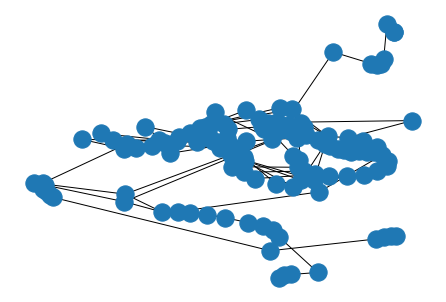

In [105]:
nx.draw(K)

## 3. Add Centroids To Graph

In [106]:
def add_centroids(G, metro, municip, namecol="admin2RefN", add=True, walk_speed = 10, **kwargs):
    """
    Adds centroids of municipality to graph as well as edges 
    between centroids and closest metro stops
    
    walk_speed: meters per minute
    """
    
    # distance from each centroid to a metro station
    mout = [metro_dist(municip.iloc[x], metro, **kwargs) for x in range(10)]
    
    # create new nodes,edges for each municipality
    offset = 1000
    # muni index list
    muni_index = list(range(offset, offset+len(municip)))
    muni_nodes = dict.fromkeys(muni_index)
    edges = []
    
    # assign name attribute, index attribute, create edges
    for i in range(len(municip)):
        muni_nodes[offset + i] = {"muni_index":i, "muni_name" : municip.loc[i,namecol]}
        edges.append((offset+i, mout[i][1], mout[i][0]*walk_speed))    
        
    # add to graph
    if add:
        # add nodes
        G.add_nodes_from(list(muni_nodes.keys()))
        nx.set_node_attributes(G, muni_nodes)
        # add edges
        G.add_weighted_edges_from(edges)
        return G, muni_index
    
    return muni_nodes, edges

## 4. Compute Cost Matrix

In [107]:
def cost_between_indices(G, lst, method="dijkstra"):
    """
    Creates a matrix of size len(lst)^2 where entry
    c_ij contains the cost of traveling from node i to
    node j through graph G
    """
    
    n = len(lst)
    cost = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            cost[i,j] = nx.dijkstra_path_length(G,lst[i],lst[j])
    
    return cost

In [108]:
def cost_from_metro(metro, municip, **kwargs):
    """
    Creates a cost matrix for traveling between the centroids 
    of all municipalities
    """
    
    # create graph
    G = metro_to_graph(metro, **kwargs)
    # add centroids
    G, muni_index = add_centroids(G, metro, municip, **kwargs)
    
    return cost_between_indices(G, muni_index)

In [109]:
cost = cost_from_metro(metro, municip, speed=transit_speed, wait=transit_wait, comunas=comunas) # additional keywords: wait=transit_wait, speed=transit_speed

POINT (434675.7919213748 692192.2225191436)
0
POINT (463004.7889141612 712183.1486992474)
1
POINT (438013.1865059877 700387.4382481903)
2
POINT (429894.6201873018 670780.9708415892)
3
POINT (443834.6943574236 702180.6327056983)
4
POINT (436378.2153932683 681400.2190503889)
5
POINT (450319.9976041996 705644.1464286316)
6
POINT (431701.0401266101 683046.1169005791)
7
POINT (427913.515973477 679331.5768946405)
8
POINT (431904.0842491058 679392.1499651098)
9


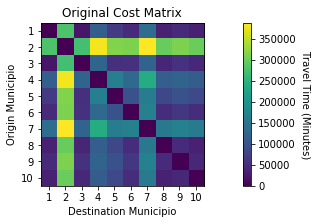

In [110]:
# visualize travel cost
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,3))

cbarimg = axes.imshow(cost, extent=[0.5,10.5,10.5,0.5])
axes.set_title("Original Cost Matrix")
axes.set_xticks(list(range(1,11)))
axes.set_yticks(list(range(1,11)))
axes.set_xlabel("Destination Municipio")
axes.set_ylabel("Origin Municipio")

cbar = plt.colorbar(cbarimg)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Travel Time (Minutes)', rotation=270)

plt.show()

## Instead of Centroids - Centroid of Comunas

In [111]:
muni_names

['Medellin',
 'Barbosa',
 'Bello',
 'Caldas',
 'Copacabana',
 'Envigado',
 'Girardota',
 'Itagui',
 'La Estrella',
 'Sabaneta']

In [32]:
comunas = projected(spatial_csv("comunas_new.csv"))

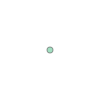

In [76]:
MultiPoint(comunas[comunas["muni_index"]==8].geometry.tolist()).centroid

In [43]:
def test_kwargs(**kwargs):
    print("banana" in kwargs.keys())

In [72]:
type(municip.iloc[5].geometry.centroid)

shapely.geometry.point.Point

In [79]:
center = muni_center(5, comunas) #municip.iloc[5].geometry.centroid

nearest_points(center, MultiPoint(comunas[comunas["muni_index"]==8].geometry.tolist()))

(<shapely.geometry.point.Point at 0x101c62b630>,
 <shapely.geometry.point.Point at 0x101c62be48>)

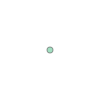

In [77]:
muni_center(5, comunas)

In [ ]:
if "comunas" in kwargs.keys():
    for i in range(len(municip)):
        municip.loc[i, "geometry"] = MultiPoint(comunas[comunas["muni_index"]==i].geometry.tolist()).centroid